# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [81]:
data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

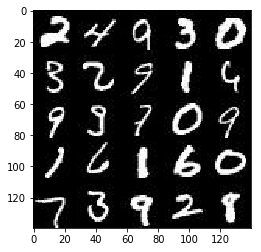

In [82]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

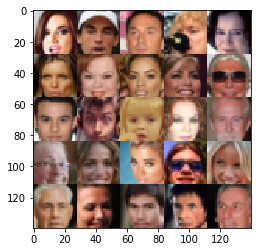

In [83]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [84]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [85]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [93]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Convolution Layer 1: 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        relu1 = tf.maximum(alpha * x1, x1)
        
        # Convolution Layer 2
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.layers.dropout(relu2, rate=0.2)

        
        # Convolution Layer 3
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.layers.dropout(relu3, rate=0.2)
        
        # Flatten
        x4 = tf.reshape(drop3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(x4, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [94]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        # Fully Connected Layer 1: 7x7x1024
        x1 = tf.layers.dense(z, 7 * 7 * 1024)
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # Convolution Layer 2
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.layers.dropout(relu2, rate=0.2)
        
        # Convolution Layer 3
        x3 = tf.layers.conv2d_transpose(drop2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.layers.dropout(relu3, rate=0.2)
        
        # Output Layer 
        logits = tf.layers.conv2d_transpose(drop3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [95]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # One-sided Label Smoothing
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [96]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    for t in t_vars:
        assert t in d_vars or t in g_vars
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [97]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [98]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0

    input_real, input_z, learning_rate_ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Normalize
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_: learning_rate})
                
                if steps % 25 == 0:
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_train_loss = g_loss.eval({input_z: batch_z})

                    print("Epoch Number: {}/{},".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.6f},".format(d_train_loss),
                          "Generator Loss: {:.6f}".format(g_train_loss))
                    
                if steps % 100 == 0:
                    _ = show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch Number: 1/2, Discriminator Loss: 0.467316, Generator Loss: 15.473387
Epoch Number: 1/2, Discriminator Loss: 0.334143, Generator Loss: 8.315475
Epoch Number: 1/2, Discriminator Loss: 0.330052, Generator Loss: 6.690515
Epoch Number: 1/2, Discriminator Loss: 0.341298, Generator Loss: 5.414697


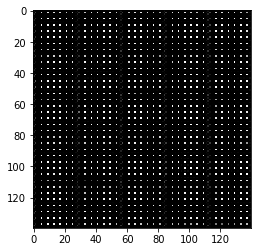

Epoch Number: 1/2, Discriminator Loss: 0.504148, Generator Loss: 8.479006
Epoch Number: 1/2, Discriminator Loss: 0.344107, Generator Loss: 5.904410
Epoch Number: 1/2, Discriminator Loss: 0.341262, Generator Loss: 6.395106
Epoch Number: 1/2, Discriminator Loss: 0.341753, Generator Loss: 5.110572


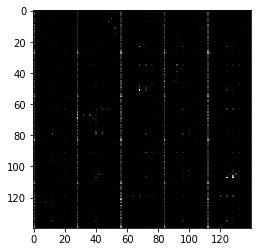

Epoch Number: 1/2, Discriminator Loss: 1.723566, Generator Loss: 1.046442
Epoch Number: 1/2, Discriminator Loss: 0.821478, Generator Loss: 1.361414
Epoch Number: 1/2, Discriminator Loss: 1.933900, Generator Loss: 0.333970
Epoch Number: 1/2, Discriminator Loss: 1.119673, Generator Loss: 0.864484


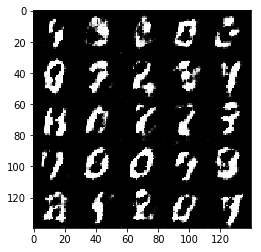

Epoch Number: 1/2, Discriminator Loss: 0.914008, Generator Loss: 1.058407
Epoch Number: 1/2, Discriminator Loss: 0.788810, Generator Loss: 1.408045
Epoch Number: 1/2, Discriminator Loss: 1.599939, Generator Loss: 0.439738
Epoch Number: 1/2, Discriminator Loss: 1.174425, Generator Loss: 1.565574


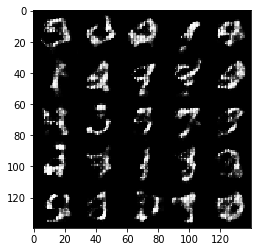

Epoch Number: 1/2, Discriminator Loss: 1.099637, Generator Loss: 1.062732
Epoch Number: 1/2, Discriminator Loss: 1.089863, Generator Loss: 1.031631
Epoch Number: 1/2, Discriminator Loss: 1.270926, Generator Loss: 0.741286
Epoch Number: 1/2, Discriminator Loss: 1.130482, Generator Loss: 0.823779


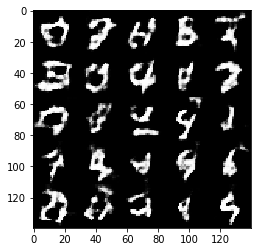

Epoch Number: 1/2, Discriminator Loss: 1.218867, Generator Loss: 1.011615
Epoch Number: 1/2, Discriminator Loss: 1.239703, Generator Loss: 0.736666
Epoch Number: 1/2, Discriminator Loss: 1.215778, Generator Loss: 0.836982
Epoch Number: 1/2, Discriminator Loss: 1.086749, Generator Loss: 1.217854


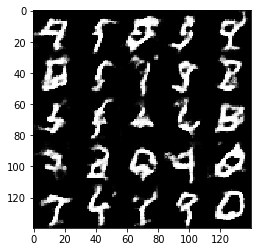

Epoch Number: 1/2, Discriminator Loss: 1.193182, Generator Loss: 0.900956
Epoch Number: 1/2, Discriminator Loss: 1.113579, Generator Loss: 0.886997
Epoch Number: 1/2, Discriminator Loss: 1.347583, Generator Loss: 0.599193
Epoch Number: 1/2, Discriminator Loss: 1.286311, Generator Loss: 0.693744


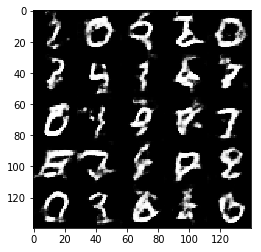

Epoch Number: 1/2, Discriminator Loss: 1.166610, Generator Loss: 0.724490
Epoch Number: 1/2, Discriminator Loss: 1.211167, Generator Loss: 0.636049
Epoch Number: 1/2, Discriminator Loss: 1.052225, Generator Loss: 0.797577
Epoch Number: 1/2, Discriminator Loss: 1.260475, Generator Loss: 0.697835


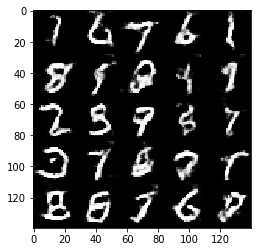

Epoch Number: 1/2, Discriminator Loss: 1.078156, Generator Loss: 0.956457
Epoch Number: 1/2, Discriminator Loss: 1.016228, Generator Loss: 1.031387
Epoch Number: 1/2, Discriminator Loss: 1.196322, Generator Loss: 0.852899
Epoch Number: 1/2, Discriminator Loss: 1.121091, Generator Loss: 1.323397


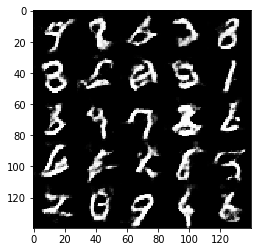

Epoch Number: 1/2, Discriminator Loss: 1.224272, Generator Loss: 1.444357
Epoch Number: 1/2, Discriminator Loss: 0.952668, Generator Loss: 1.101959
Epoch Number: 1/2, Discriminator Loss: 0.855413, Generator Loss: 1.516104
Epoch Number: 1/2, Discriminator Loss: 1.283359, Generator Loss: 0.602516


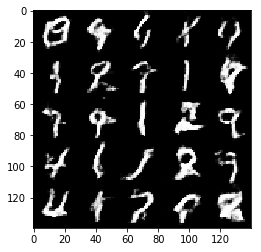

Epoch Number: 1/2, Discriminator Loss: 1.117708, Generator Loss: 0.802241
Epoch Number: 1/2, Discriminator Loss: 1.039469, Generator Loss: 0.821608
Epoch Number: 1/2, Discriminator Loss: 1.396983, Generator Loss: 0.496926
Epoch Number: 1/2, Discriminator Loss: 0.963365, Generator Loss: 1.089455


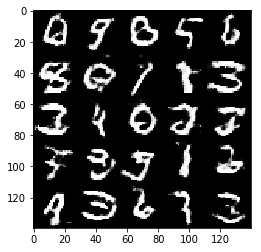

Epoch Number: 1/2, Discriminator Loss: 1.179638, Generator Loss: 1.121495
Epoch Number: 1/2, Discriminator Loss: 1.336897, Generator Loss: 0.543016
Epoch Number: 1/2, Discriminator Loss: 1.360257, Generator Loss: 0.586135
Epoch Number: 1/2, Discriminator Loss: 1.131132, Generator Loss: 0.746885


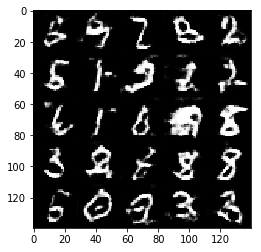

Epoch Number: 1/2, Discriminator Loss: 1.332036, Generator Loss: 0.840283
Epoch Number: 1/2, Discriminator Loss: 0.865103, Generator Loss: 1.270277
Epoch Number: 1/2, Discriminator Loss: 1.119632, Generator Loss: 0.781326
Epoch Number: 1/2, Discriminator Loss: 1.213878, Generator Loss: 0.708000


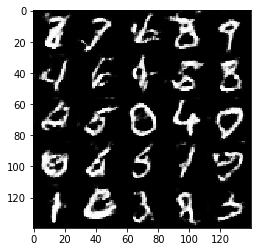

Epoch Number: 1/2, Discriminator Loss: 1.068483, Generator Loss: 1.074530
Epoch Number: 1/2, Discriminator Loss: 1.205048, Generator Loss: 2.538639
Epoch Number: 1/2, Discriminator Loss: 1.046125, Generator Loss: 0.835728
Epoch Number: 1/2, Discriminator Loss: 0.987958, Generator Loss: 1.457139


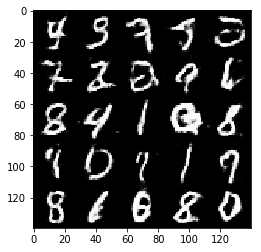

Epoch Number: 1/2, Discriminator Loss: 0.903688, Generator Loss: 1.197789
Epoch Number: 1/2, Discriminator Loss: 0.976012, Generator Loss: 1.052594
Epoch Number: 1/2, Discriminator Loss: 1.248369, Generator Loss: 0.701084
Epoch Number: 1/2, Discriminator Loss: 1.373489, Generator Loss: 0.641659


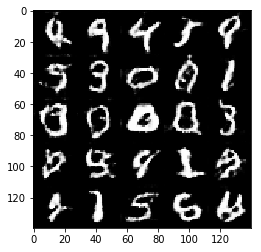

Epoch Number: 1/2, Discriminator Loss: 1.049246, Generator Loss: 0.882398
Epoch Number: 1/2, Discriminator Loss: 1.034270, Generator Loss: 1.010701
Epoch Number: 1/2, Discriminator Loss: 1.103729, Generator Loss: 0.823817
Epoch Number: 1/2, Discriminator Loss: 1.009566, Generator Loss: 0.927324


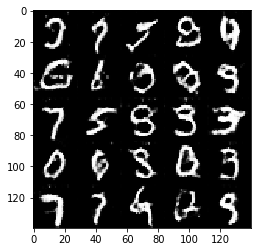

Epoch Number: 1/2, Discriminator Loss: 0.879941, Generator Loss: 1.292274
Epoch Number: 1/2, Discriminator Loss: 1.015688, Generator Loss: 0.837249
Epoch Number: 1/2, Discriminator Loss: 0.877897, Generator Loss: 1.583778
Epoch Number: 1/2, Discriminator Loss: 1.164122, Generator Loss: 0.698845


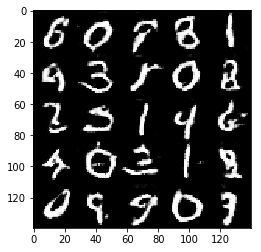

Epoch Number: 1/2, Discriminator Loss: 1.253972, Generator Loss: 0.656576
Epoch Number: 1/2, Discriminator Loss: 1.122467, Generator Loss: 0.799564
Epoch Number: 1/2, Discriminator Loss: 0.841359, Generator Loss: 1.322373
Epoch Number: 1/2, Discriminator Loss: 0.864793, Generator Loss: 1.558517


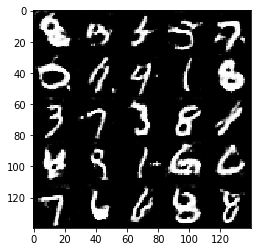

Epoch Number: 1/2, Discriminator Loss: 0.968307, Generator Loss: 0.995486
Epoch Number: 1/2, Discriminator Loss: 0.888818, Generator Loss: 1.098532
Epoch Number: 1/2, Discriminator Loss: 1.782878, Generator Loss: 0.341075
Epoch Number: 2/2, Discriminator Loss: 0.779259, Generator Loss: 1.546725


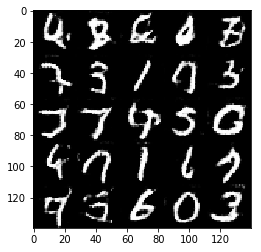

Epoch Number: 2/2, Discriminator Loss: 1.098562, Generator Loss: 1.420836
Epoch Number: 2/2, Discriminator Loss: 1.039274, Generator Loss: 0.822093
Epoch Number: 2/2, Discriminator Loss: 0.901691, Generator Loss: 1.209706
Epoch Number: 2/2, Discriminator Loss: 0.927543, Generator Loss: 1.216972


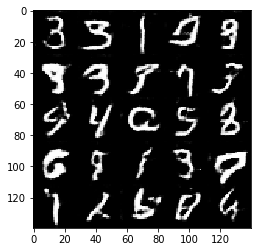

Epoch Number: 2/2, Discriminator Loss: 0.945573, Generator Loss: 1.089609
Epoch Number: 2/2, Discriminator Loss: 1.171582, Generator Loss: 0.780635
Epoch Number: 2/2, Discriminator Loss: 1.087472, Generator Loss: 0.776550
Epoch Number: 2/2, Discriminator Loss: 0.739116, Generator Loss: 1.458784


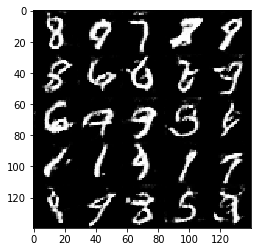

Epoch Number: 2/2, Discriminator Loss: 1.282387, Generator Loss: 0.609725
Epoch Number: 2/2, Discriminator Loss: 1.048135, Generator Loss: 0.872106
Epoch Number: 2/2, Discriminator Loss: 0.937162, Generator Loss: 1.009454
Epoch Number: 2/2, Discriminator Loss: 1.844411, Generator Loss: 0.380811


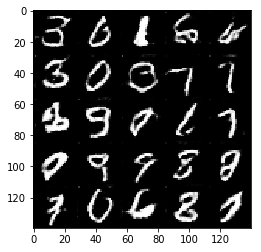

Epoch Number: 2/2, Discriminator Loss: 1.173914, Generator Loss: 0.710168
Epoch Number: 2/2, Discriminator Loss: 0.735136, Generator Loss: 1.648914
Epoch Number: 2/2, Discriminator Loss: 0.968682, Generator Loss: 1.010148
Epoch Number: 2/2, Discriminator Loss: 0.919721, Generator Loss: 0.952653


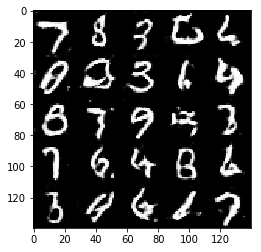

Epoch Number: 2/2, Discriminator Loss: 0.885995, Generator Loss: 1.631603
Epoch Number: 2/2, Discriminator Loss: 1.180085, Generator Loss: 0.864665
Epoch Number: 2/2, Discriminator Loss: 1.273877, Generator Loss: 0.613468
Epoch Number: 2/2, Discriminator Loss: 0.982346, Generator Loss: 0.891178


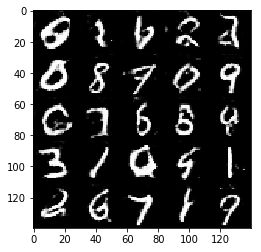

Epoch Number: 2/2, Discriminator Loss: 0.831675, Generator Loss: 1.245832
Epoch Number: 2/2, Discriminator Loss: 0.903069, Generator Loss: 1.066549
Epoch Number: 2/2, Discriminator Loss: 1.235953, Generator Loss: 0.603585
Epoch Number: 2/2, Discriminator Loss: 0.935669, Generator Loss: 1.044349


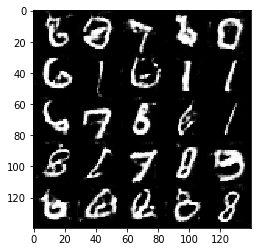

Epoch Number: 2/2, Discriminator Loss: 0.918104, Generator Loss: 0.988381
Epoch Number: 2/2, Discriminator Loss: 0.874067, Generator Loss: 1.048946
Epoch Number: 2/2, Discriminator Loss: 1.021096, Generator Loss: 0.821144
Epoch Number: 2/2, Discriminator Loss: 0.839049, Generator Loss: 1.457828


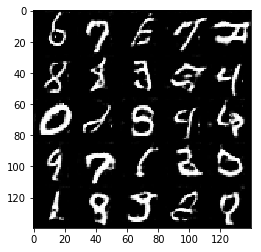

Epoch Number: 2/2, Discriminator Loss: 1.017763, Generator Loss: 0.865574
Epoch Number: 2/2, Discriminator Loss: 1.051865, Generator Loss: 0.825565
Epoch Number: 2/2, Discriminator Loss: 0.964008, Generator Loss: 1.579893
Epoch Number: 2/2, Discriminator Loss: 0.773426, Generator Loss: 2.164202


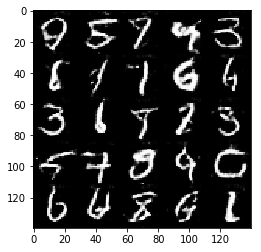

Epoch Number: 2/2, Discriminator Loss: 0.784899, Generator Loss: 1.282602
Epoch Number: 2/2, Discriminator Loss: 1.180506, Generator Loss: 0.754032
Epoch Number: 2/2, Discriminator Loss: 0.821847, Generator Loss: 1.160592
Epoch Number: 2/2, Discriminator Loss: 0.970513, Generator Loss: 2.290532


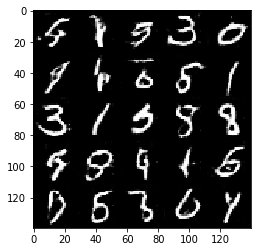

Epoch Number: 2/2, Discriminator Loss: 0.771098, Generator Loss: 2.020857
Epoch Number: 2/2, Discriminator Loss: 0.948777, Generator Loss: 0.994340
Epoch Number: 2/2, Discriminator Loss: 0.962379, Generator Loss: 1.428170
Epoch Number: 2/2, Discriminator Loss: 0.822542, Generator Loss: 1.099609


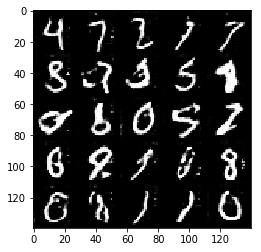

Epoch Number: 2/2, Discriminator Loss: 0.670528, Generator Loss: 1.841596
Epoch Number: 2/2, Discriminator Loss: 0.609981, Generator Loss: 1.766716
Epoch Number: 2/2, Discriminator Loss: 0.719239, Generator Loss: 1.621967
Epoch Number: 2/2, Discriminator Loss: 0.746710, Generator Loss: 1.389158


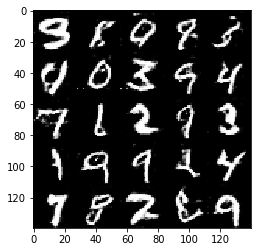

Epoch Number: 2/2, Discriminator Loss: 0.858297, Generator Loss: 1.098694
Epoch Number: 2/2, Discriminator Loss: 0.920763, Generator Loss: 1.071259
Epoch Number: 2/2, Discriminator Loss: 0.959766, Generator Loss: 2.064133
Epoch Number: 2/2, Discriminator Loss: 1.072127, Generator Loss: 0.857283


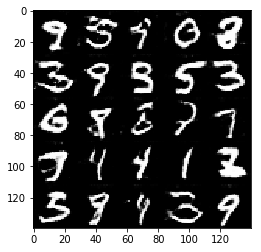

Epoch Number: 2/2, Discriminator Loss: 1.128390, Generator Loss: 0.753585
Epoch Number: 2/2, Discriminator Loss: 0.900865, Generator Loss: 0.977608
Epoch Number: 2/2, Discriminator Loss: 0.688692, Generator Loss: 1.464103
Epoch Number: 2/2, Discriminator Loss: 1.182219, Generator Loss: 1.433252


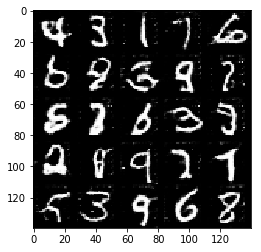

Epoch Number: 2/2, Discriminator Loss: 0.810164, Generator Loss: 1.332299
Epoch Number: 2/2, Discriminator Loss: 1.335932, Generator Loss: 0.539394
Epoch Number: 2/2, Discriminator Loss: 0.856674, Generator Loss: 1.519550
Epoch Number: 2/2, Discriminator Loss: 0.841044, Generator Loss: 1.275516


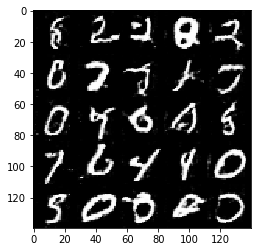

Epoch Number: 2/2, Discriminator Loss: 0.704455, Generator Loss: 1.407531
Epoch Number: 2/2, Discriminator Loss: 0.868398, Generator Loss: 1.128727
Epoch Number: 2/2, Discriminator Loss: 0.784758, Generator Loss: 1.271670
Epoch Number: 2/2, Discriminator Loss: 0.827435, Generator Loss: 1.076244


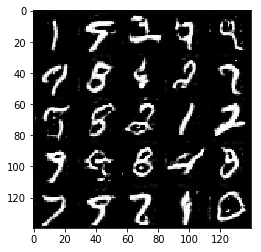

Epoch Number: 2/2, Discriminator Loss: 1.007310, Generator Loss: 1.899611
Epoch Number: 2/2, Discriminator Loss: 1.335504, Generator Loss: 0.562874
Epoch Number: 2/2, Discriminator Loss: 1.091587, Generator Loss: 0.794576
Epoch Number: 2/2, Discriminator Loss: 1.019091, Generator Loss: 0.856821


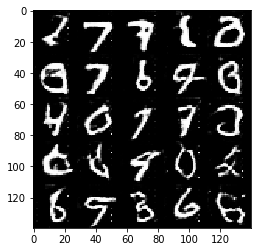

Epoch Number: 2/2, Discriminator Loss: 1.065607, Generator Loss: 0.825714
Epoch Number: 2/2, Discriminator Loss: 0.718348, Generator Loss: 1.507898
Epoch Number: 2/2, Discriminator Loss: 0.860258, Generator Loss: 1.433815
Epoch Number: 2/2, Discriminator Loss: 0.718943, Generator Loss: 1.460001


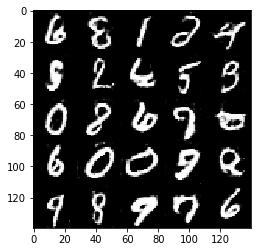

Epoch Number: 2/2, Discriminator Loss: 0.989046, Generator Loss: 0.917177
Epoch Number: 2/2, Discriminator Loss: 0.672482, Generator Loss: 1.528841
Epoch Number: 2/2, Discriminator Loss: 0.766362, Generator Loss: 1.391727
Epoch Number: 2/2, Discriminator Loss: 1.073441, Generator Loss: 0.858483


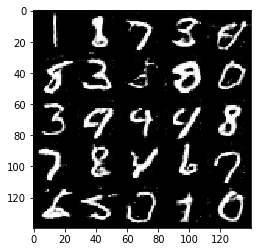

Epoch Number: 2/2, Discriminator Loss: 0.795633, Generator Loss: 1.423376
Epoch Number: 2/2, Discriminator Loss: 1.378335, Generator Loss: 0.588789


In [100]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch Number: 1/1, Discriminator Loss: 0.392086, Generator Loss: 4.445734
Epoch Number: 1/1, Discriminator Loss: 0.364010, Generator Loss: 3.858790
Epoch Number: 1/1, Discriminator Loss: 0.381803, Generator Loss: 4.466072
Epoch Number: 1/1, Discriminator Loss: 0.533605, Generator Loss: 2.178289


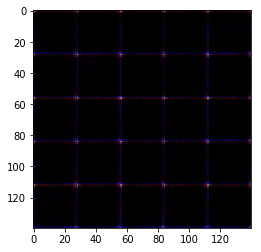

Epoch Number: 1/1, Discriminator Loss: 1.143304, Generator Loss: 0.714261


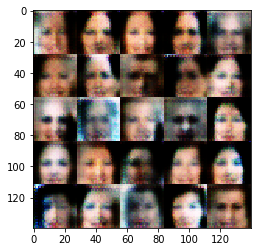

Epoch Number: 1/1, Discriminator Loss: 2.120235, Generator Loss: 0.262274
Epoch Number: 1/1, Discriminator Loss: 1.067625, Generator Loss: 1.024875
Epoch Number: 1/1, Discriminator Loss: 1.218306, Generator Loss: 1.033478
Epoch Number: 1/1, Discriminator Loss: 1.839305, Generator Loss: 2.377907


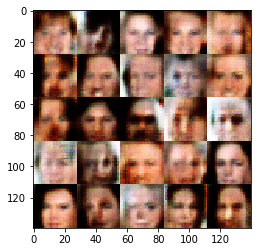

Epoch Number: 1/1, Discriminator Loss: 1.529331, Generator Loss: 0.972042
Epoch Number: 1/1, Discriminator Loss: 1.395990, Generator Loss: 1.443630
Epoch Number: 1/1, Discriminator Loss: 0.779487, Generator Loss: 1.472937
Epoch Number: 1/1, Discriminator Loss: 1.069013, Generator Loss: 0.884858


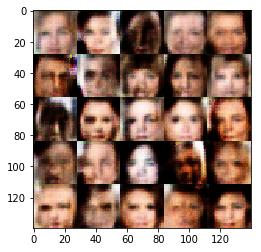

Epoch Number: 1/1, Discriminator Loss: 0.734883, Generator Loss: 1.758617
Epoch Number: 1/1, Discriminator Loss: 0.657897, Generator Loss: 1.838807
Epoch Number: 1/1, Discriminator Loss: 0.654737, Generator Loss: 2.651168
Epoch Number: 1/1, Discriminator Loss: 1.273237, Generator Loss: 1.095425


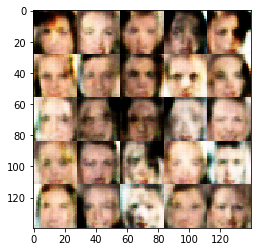

Epoch Number: 1/1, Discriminator Loss: 1.403040, Generator Loss: 0.591163
Epoch Number: 1/1, Discriminator Loss: 0.904191, Generator Loss: 1.067406
Epoch Number: 1/1, Discriminator Loss: 1.301295, Generator Loss: 0.550136
Epoch Number: 1/1, Discriminator Loss: 1.049567, Generator Loss: 1.510413


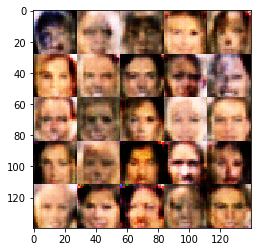

Epoch Number: 1/1, Discriminator Loss: 1.254967, Generator Loss: 0.919051
Epoch Number: 1/1, Discriminator Loss: 1.198386, Generator Loss: 0.682606
Epoch Number: 1/1, Discriminator Loss: 0.812325, Generator Loss: 1.733963
Epoch Number: 1/1, Discriminator Loss: 1.036617, Generator Loss: 0.895932


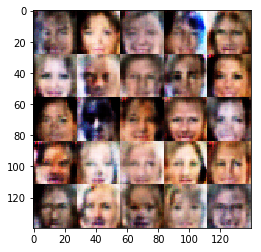

Epoch Number: 1/1, Discriminator Loss: 0.777599, Generator Loss: 1.286172
Epoch Number: 1/1, Discriminator Loss: 0.723453, Generator Loss: 1.521292
Epoch Number: 1/1, Discriminator Loss: 0.952771, Generator Loss: 1.184614
Epoch Number: 1/1, Discriminator Loss: 1.057270, Generator Loss: 1.860277


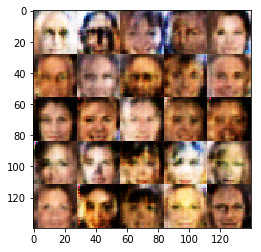

Epoch Number: 1/1, Discriminator Loss: 0.641332, Generator Loss: 3.028922
Epoch Number: 1/1, Discriminator Loss: 0.649189, Generator Loss: 2.403075
Epoch Number: 1/1, Discriminator Loss: 0.723671, Generator Loss: 1.793935
Epoch Number: 1/1, Discriminator Loss: 1.200105, Generator Loss: 1.688563


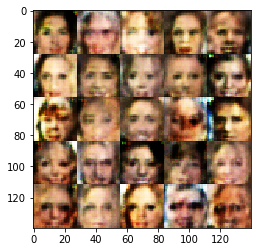

Epoch Number: 1/1, Discriminator Loss: 0.673672, Generator Loss: 2.044986
Epoch Number: 1/1, Discriminator Loss: 0.947160, Generator Loss: 1.257848
Epoch Number: 1/1, Discriminator Loss: 1.216169, Generator Loss: 0.638209
Epoch Number: 1/1, Discriminator Loss: 0.969704, Generator Loss: 0.995473


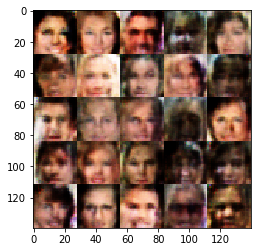

Epoch Number: 1/1, Discriminator Loss: 0.876711, Generator Loss: 2.074869
Epoch Number: 1/1, Discriminator Loss: 0.749879, Generator Loss: 1.707983
Epoch Number: 1/1, Discriminator Loss: 0.854477, Generator Loss: 1.401115
Epoch Number: 1/1, Discriminator Loss: 1.040867, Generator Loss: 1.223359


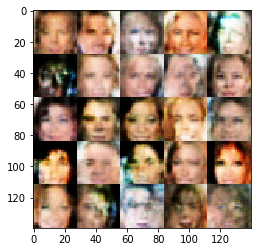

Epoch Number: 1/1, Discriminator Loss: 0.848429, Generator Loss: 1.291319
Epoch Number: 1/1, Discriminator Loss: 0.884105, Generator Loss: 1.370453
Epoch Number: 1/1, Discriminator Loss: 1.134034, Generator Loss: 0.688929
Epoch Number: 1/1, Discriminator Loss: 1.056460, Generator Loss: 4.042966


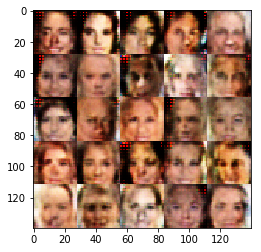

Epoch Number: 1/1, Discriminator Loss: 0.892060, Generator Loss: 1.405167
Epoch Number: 1/1, Discriminator Loss: 0.626774, Generator Loss: 2.100268
Epoch Number: 1/1, Discriminator Loss: 0.905082, Generator Loss: 1.163646
Epoch Number: 1/1, Discriminator Loss: 1.013919, Generator Loss: 0.782742


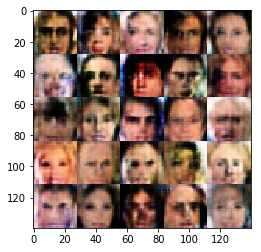

Epoch Number: 1/1, Discriminator Loss: 0.703885, Generator Loss: 1.710480
Epoch Number: 1/1, Discriminator Loss: 1.116610, Generator Loss: 0.793436
Epoch Number: 1/1, Discriminator Loss: 0.685216, Generator Loss: 1.834318
Epoch Number: 1/1, Discriminator Loss: 1.548667, Generator Loss: 2.204857


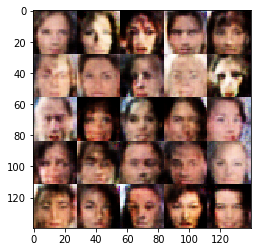

Epoch Number: 1/1, Discriminator Loss: 0.726904, Generator Loss: 1.679465
Epoch Number: 1/1, Discriminator Loss: 0.633090, Generator Loss: 3.649197
Epoch Number: 1/1, Discriminator Loss: 1.472909, Generator Loss: 0.545906
Epoch Number: 1/1, Discriminator Loss: 0.611480, Generator Loss: 1.817810


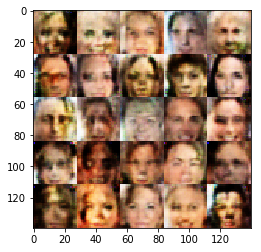

Epoch Number: 1/1, Discriminator Loss: 0.479753, Generator Loss: 2.426135
Epoch Number: 1/1, Discriminator Loss: 0.759074, Generator Loss: 1.279823
Epoch Number: 1/1, Discriminator Loss: 0.998851, Generator Loss: 1.240332
Epoch Number: 1/1, Discriminator Loss: 0.391757, Generator Loss: 3.827980


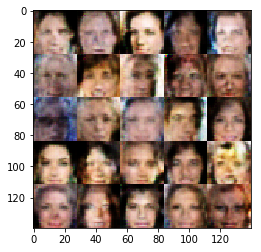

Epoch Number: 1/1, Discriminator Loss: 1.841310, Generator Loss: 0.269215
Epoch Number: 1/1, Discriminator Loss: 0.654854, Generator Loss: 1.446583
Epoch Number: 1/1, Discriminator Loss: 1.030484, Generator Loss: 0.987378
Epoch Number: 1/1, Discriminator Loss: 1.379674, Generator Loss: 0.485381


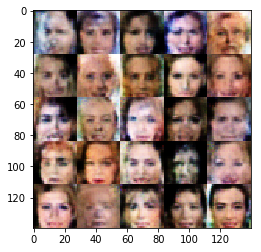

Epoch Number: 1/1, Discriminator Loss: 0.543219, Generator Loss: 2.745417
Epoch Number: 1/1, Discriminator Loss: 1.497949, Generator Loss: 0.464173
Epoch Number: 1/1, Discriminator Loss: 1.211871, Generator Loss: 1.991762
Epoch Number: 1/1, Discriminator Loss: 1.533120, Generator Loss: 0.483843


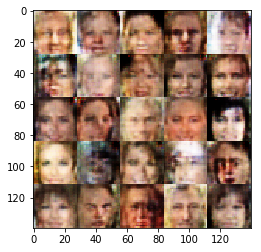

Epoch Number: 1/1, Discriminator Loss: 0.749251, Generator Loss: 1.325559
Epoch Number: 1/1, Discriminator Loss: 1.190944, Generator Loss: 0.885208
Epoch Number: 1/1, Discriminator Loss: 0.996500, Generator Loss: 2.000179
Epoch Number: 1/1, Discriminator Loss: 0.694030, Generator Loss: 1.407153


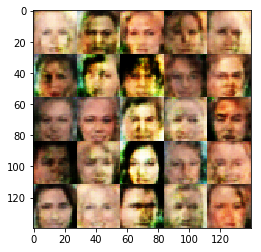

Epoch Number: 1/1, Discriminator Loss: 0.734168, Generator Loss: 1.966156
Epoch Number: 1/1, Discriminator Loss: 0.791229, Generator Loss: 1.747868
Epoch Number: 1/1, Discriminator Loss: 0.850395, Generator Loss: 1.973004
Epoch Number: 1/1, Discriminator Loss: 0.530523, Generator Loss: 2.057631


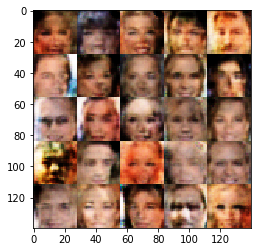

Epoch Number: 1/1, Discriminator Loss: 1.066239, Generator Loss: 0.703606
Epoch Number: 1/1, Discriminator Loss: 0.622213, Generator Loss: 1.882573
Epoch Number: 1/1, Discriminator Loss: 1.786089, Generator Loss: 0.288454
Epoch Number: 1/1, Discriminator Loss: 1.153433, Generator Loss: 0.668989


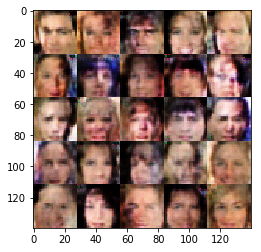

Epoch Number: 1/1, Discriminator Loss: 1.046801, Generator Loss: 1.319423
Epoch Number: 1/1, Discriminator Loss: 1.100094, Generator Loss: 0.745482
Epoch Number: 1/1, Discriminator Loss: 0.673282, Generator Loss: 1.399048
Epoch Number: 1/1, Discriminator Loss: 0.680829, Generator Loss: 1.775639


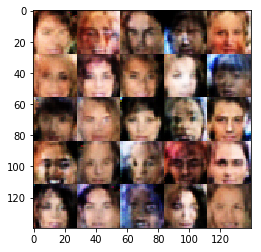

Epoch Number: 1/1, Discriminator Loss: 0.759696, Generator Loss: 1.942679
Epoch Number: 1/1, Discriminator Loss: 0.540478, Generator Loss: 2.009884
Epoch Number: 1/1, Discriminator Loss: 1.428687, Generator Loss: 0.474202
Epoch Number: 1/1, Discriminator Loss: 2.039117, Generator Loss: 2.596167


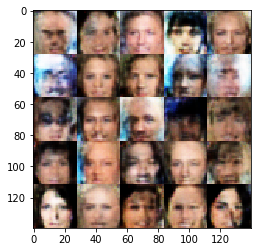

Epoch Number: 1/1, Discriminator Loss: 1.192516, Generator Loss: 1.724765
Epoch Number: 1/1, Discriminator Loss: 0.579722, Generator Loss: 2.191830
Epoch Number: 1/1, Discriminator Loss: 0.998209, Generator Loss: 1.110408
Epoch Number: 1/1, Discriminator Loss: 0.472966, Generator Loss: 3.134759


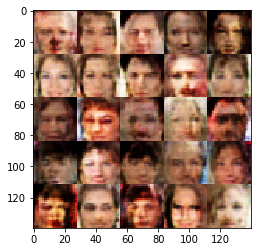

Epoch Number: 1/1, Discriminator Loss: 2.234969, Generator Loss: 4.005588
Epoch Number: 1/1, Discriminator Loss: 0.524709, Generator Loss: 3.540006
Epoch Number: 1/1, Discriminator Loss: 0.651462, Generator Loss: 2.409396
Epoch Number: 1/1, Discriminator Loss: 0.758752, Generator Loss: 1.589398


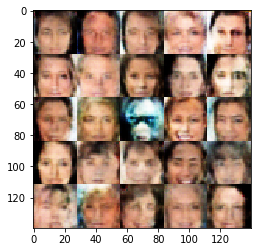

Epoch Number: 1/1, Discriminator Loss: 1.371075, Generator Loss: 0.573600
Epoch Number: 1/1, Discriminator Loss: 0.537362, Generator Loss: 2.081299
Epoch Number: 1/1, Discriminator Loss: 0.933353, Generator Loss: 0.951308
Epoch Number: 1/1, Discriminator Loss: 0.995403, Generator Loss: 0.958914


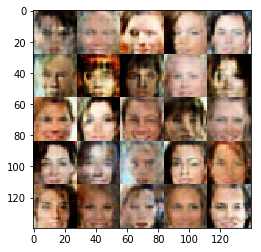

Epoch Number: 1/1, Discriminator Loss: 1.136832, Generator Loss: 0.732171
Epoch Number: 1/1, Discriminator Loss: 0.980925, Generator Loss: 0.897780
Epoch Number: 1/1, Discriminator Loss: 0.929752, Generator Loss: 1.354515
Epoch Number: 1/1, Discriminator Loss: 1.527560, Generator Loss: 2.149624


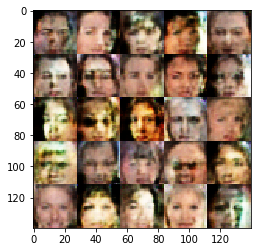

Epoch Number: 1/1, Discriminator Loss: 0.538618, Generator Loss: 2.118014
Epoch Number: 1/1, Discriminator Loss: 0.881458, Generator Loss: 1.032150
Epoch Number: 1/1, Discriminator Loss: 1.012929, Generator Loss: 0.848194
Epoch Number: 1/1, Discriminator Loss: 0.384959, Generator Loss: 3.699700


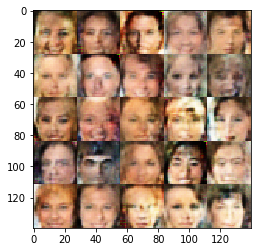

Epoch Number: 1/1, Discriminator Loss: 0.743111, Generator Loss: 1.293406
Epoch Number: 1/1, Discriminator Loss: 0.747007, Generator Loss: 1.241390
Epoch Number: 1/1, Discriminator Loss: 0.592449, Generator Loss: 3.233028
Epoch Number: 1/1, Discriminator Loss: 0.766910, Generator Loss: 1.580157


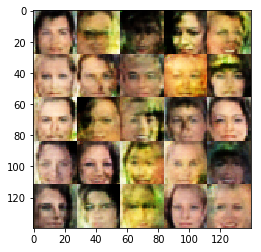

Epoch Number: 1/1, Discriminator Loss: 0.395294, Generator Loss: 3.705583
Epoch Number: 1/1, Discriminator Loss: 0.438260, Generator Loss: 3.067805
Epoch Number: 1/1, Discriminator Loss: 0.492069, Generator Loss: 2.315926
Epoch Number: 1/1, Discriminator Loss: 0.480175, Generator Loss: 2.485394


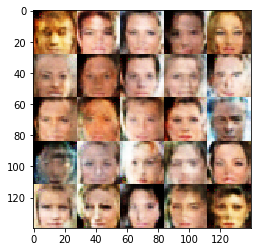

Epoch Number: 1/1, Discriminator Loss: 0.841562, Generator Loss: 1.410536
Epoch Number: 1/1, Discriminator Loss: 0.479697, Generator Loss: 2.354944
Epoch Number: 1/1, Discriminator Loss: 0.697878, Generator Loss: 1.479001
Epoch Number: 1/1, Discriminator Loss: 0.389987, Generator Loss: 4.010545


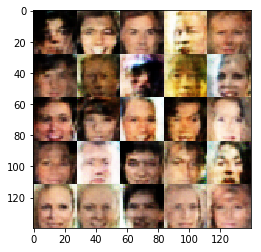

Epoch Number: 1/1, Discriminator Loss: 0.679788, Generator Loss: 1.638741
Epoch Number: 1/1, Discriminator Loss: 0.496085, Generator Loss: 2.304330
Epoch Number: 1/1, Discriminator Loss: 1.081141, Generator Loss: 1.948647
Epoch Number: 1/1, Discriminator Loss: 0.849381, Generator Loss: 1.326508


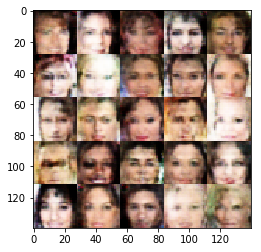

Epoch Number: 1/1, Discriminator Loss: 0.976410, Generator Loss: 0.905934
Epoch Number: 1/1, Discriminator Loss: 0.418635, Generator Loss: 2.695290
Epoch Number: 1/1, Discriminator Loss: 0.365248, Generator Loss: 3.998227
Epoch Number: 1/1, Discriminator Loss: 0.453132, Generator Loss: 2.423883


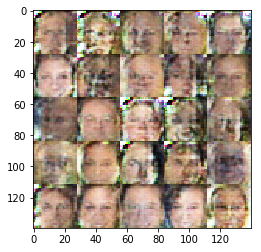

Epoch Number: 1/1, Discriminator Loss: 0.372094, Generator Loss: 3.998189
Epoch Number: 1/1, Discriminator Loss: 0.409953, Generator Loss: 2.798268
Epoch Number: 1/1, Discriminator Loss: 0.767928, Generator Loss: 1.483526
Epoch Number: 1/1, Discriminator Loss: 0.961857, Generator Loss: 1.005605


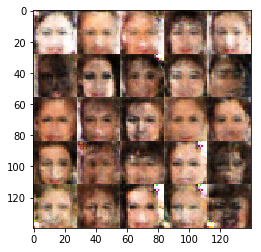

Epoch Number: 1/1, Discriminator Loss: 1.958946, Generator Loss: 0.279144
Epoch Number: 1/1, Discriminator Loss: 0.758427, Generator Loss: 1.556740
Epoch Number: 1/1, Discriminator Loss: 0.536181, Generator Loss: 3.237281
Epoch Number: 1/1, Discriminator Loss: 0.458887, Generator Loss: 2.996169


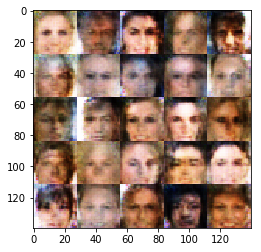

Epoch Number: 1/1, Discriminator Loss: 0.732523, Generator Loss: 1.350615
Epoch Number: 1/1, Discriminator Loss: 0.478771, Generator Loss: 2.909110
Epoch Number: 1/1, Discriminator Loss: 0.625474, Generator Loss: 1.579537
Epoch Number: 1/1, Discriminator Loss: 0.478285, Generator Loss: 2.412094


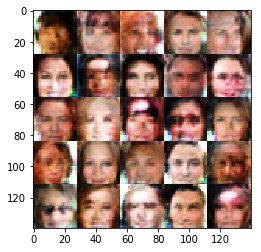

Epoch Number: 1/1, Discriminator Loss: 0.939222, Generator Loss: 1.024816
Epoch Number: 1/1, Discriminator Loss: 1.031385, Generator Loss: 0.907217
Epoch Number: 1/1, Discriminator Loss: 0.570414, Generator Loss: 1.993075
Epoch Number: 1/1, Discriminator Loss: 0.378094, Generator Loss: 3.787514


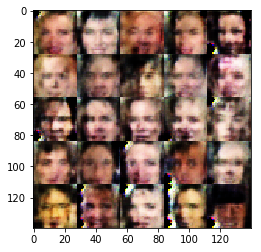

Epoch Number: 1/1, Discriminator Loss: 2.676170, Generator Loss: 4.131094
Epoch Number: 1/1, Discriminator Loss: 0.861684, Generator Loss: 1.429058
Epoch Number: 1/1, Discriminator Loss: 0.652327, Generator Loss: 1.943458
Epoch Number: 1/1, Discriminator Loss: 0.609591, Generator Loss: 1.561925


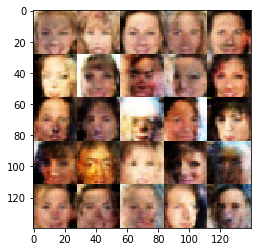

Epoch Number: 1/1, Discriminator Loss: 0.854298, Generator Loss: 1.371297
Epoch Number: 1/1, Discriminator Loss: 1.256899, Generator Loss: 0.589439
Epoch Number: 1/1, Discriminator Loss: 1.039955, Generator Loss: 0.804209
Epoch Number: 1/1, Discriminator Loss: 1.730118, Generator Loss: 2.446381


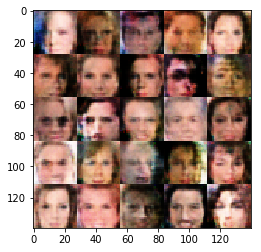

Epoch Number: 1/1, Discriminator Loss: 1.191748, Generator Loss: 0.732763
Epoch Number: 1/1, Discriminator Loss: 1.044213, Generator Loss: 1.139452
Epoch Number: 1/1, Discriminator Loss: 1.027238, Generator Loss: 0.996206
Epoch Number: 1/1, Discriminator Loss: 1.095245, Generator Loss: 1.236021


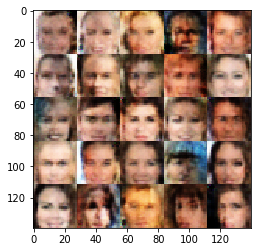

Epoch Number: 1/1, Discriminator Loss: 1.021627, Generator Loss: 1.221821
Epoch Number: 1/1, Discriminator Loss: 0.827796, Generator Loss: 1.091188
Epoch Number: 1/1, Discriminator Loss: 0.952437, Generator Loss: 1.057890
Epoch Number: 1/1, Discriminator Loss: 0.492766, Generator Loss: 2.350570


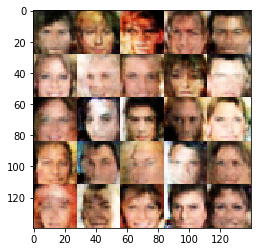

Epoch Number: 1/1, Discriminator Loss: 0.743921, Generator Loss: 1.736545
Epoch Number: 1/1, Discriminator Loss: 0.640500, Generator Loss: 1.545984
Epoch Number: 1/1, Discriminator Loss: 1.346756, Generator Loss: 0.667439
Epoch Number: 1/1, Discriminator Loss: 1.045526, Generator Loss: 0.736595


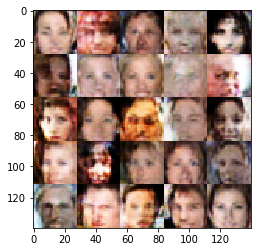

Epoch Number: 1/1, Discriminator Loss: 1.274348, Generator Loss: 0.593664
Epoch Number: 1/1, Discriminator Loss: 1.683464, Generator Loss: 0.479859
Epoch Number: 1/1, Discriminator Loss: 0.910736, Generator Loss: 1.200795
Epoch Number: 1/1, Discriminator Loss: 0.926939, Generator Loss: 1.028591


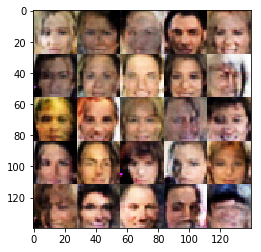

Epoch Number: 1/1, Discriminator Loss: 0.958719, Generator Loss: 1.964986
Epoch Number: 1/1, Discriminator Loss: 0.447543, Generator Loss: 2.928929
Epoch Number: 1/1, Discriminator Loss: 1.100278, Generator Loss: 0.993804
Epoch Number: 1/1, Discriminator Loss: 0.676289, Generator Loss: 1.487054


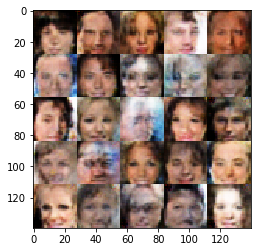

Epoch Number: 1/1, Discriminator Loss: 1.402766, Generator Loss: 1.479532
Epoch Number: 1/1, Discriminator Loss: 1.206418, Generator Loss: 0.656389
Epoch Number: 1/1, Discriminator Loss: 0.593416, Generator Loss: 1.769209
Epoch Number: 1/1, Discriminator Loss: 0.562933, Generator Loss: 1.918441


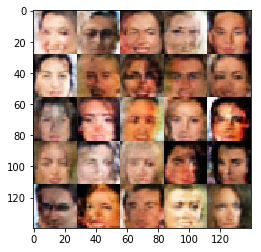

Epoch Number: 1/1, Discriminator Loss: 1.537073, Generator Loss: 0.405969
Epoch Number: 1/1, Discriminator Loss: 1.220018, Generator Loss: 0.716669
Epoch Number: 1/1, Discriminator Loss: 1.082248, Generator Loss: 0.732671
Epoch Number: 1/1, Discriminator Loss: 0.442750, Generator Loss: 2.641357


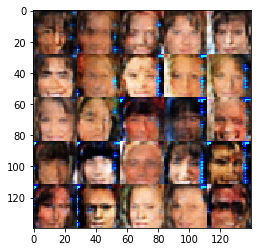

Epoch Number: 1/1, Discriminator Loss: 0.584273, Generator Loss: 2.098533
Epoch Number: 1/1, Discriminator Loss: 0.866047, Generator Loss: 0.995344
Epoch Number: 1/1, Discriminator Loss: 0.965228, Generator Loss: 1.354430
Epoch Number: 1/1, Discriminator Loss: 0.850837, Generator Loss: 1.165041


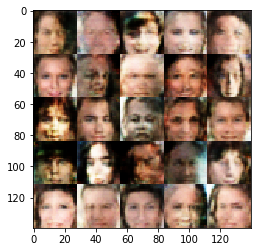

Epoch Number: 1/1, Discriminator Loss: 1.702723, Generator Loss: 1.500487
Epoch Number: 1/1, Discriminator Loss: 0.627081, Generator Loss: 1.537494
Epoch Number: 1/1, Discriminator Loss: 0.778598, Generator Loss: 1.779423
Epoch Number: 1/1, Discriminator Loss: 1.125051, Generator Loss: 0.672010


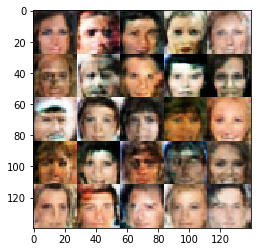

Epoch Number: 1/1, Discriminator Loss: 0.662795, Generator Loss: 1.819703
Epoch Number: 1/1, Discriminator Loss: 1.430821, Generator Loss: 0.469489
Epoch Number: 1/1, Discriminator Loss: 0.853117, Generator Loss: 1.117348
Epoch Number: 1/1, Discriminator Loss: 1.048691, Generator Loss: 1.543502


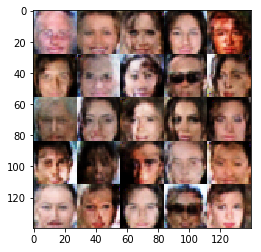

Epoch Number: 1/1, Discriminator Loss: 0.991354, Generator Loss: 1.446765
Epoch Number: 1/1, Discriminator Loss: 1.125421, Generator Loss: 0.776271
Epoch Number: 1/1, Discriminator Loss: 0.838450, Generator Loss: 2.195292
Epoch Number: 1/1, Discriminator Loss: 0.715675, Generator Loss: 1.813534


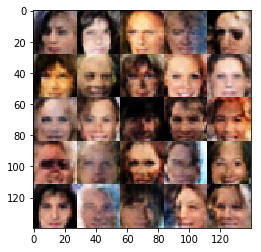

Epoch Number: 1/1, Discriminator Loss: 0.651117, Generator Loss: 1.658125
Epoch Number: 1/1, Discriminator Loss: 0.721569, Generator Loss: 2.103233
Epoch Number: 1/1, Discriminator Loss: 0.590459, Generator Loss: 1.816577
Epoch Number: 1/1, Discriminator Loss: 0.718917, Generator Loss: 1.388967


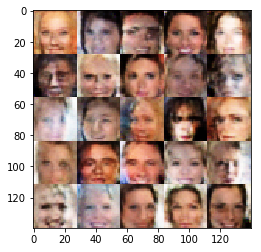

Epoch Number: 1/1, Discriminator Loss: 0.723098, Generator Loss: 1.926228
Epoch Number: 1/1, Discriminator Loss: 1.089144, Generator Loss: 0.846958
Epoch Number: 1/1, Discriminator Loss: 0.433591, Generator Loss: 3.139918
Epoch Number: 1/1, Discriminator Loss: 0.932492, Generator Loss: 1.190627


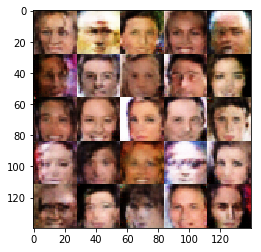

Epoch Number: 1/1, Discriminator Loss: 0.774376, Generator Loss: 1.705255
Epoch Number: 1/1, Discriminator Loss: 1.478125, Generator Loss: 1.470869
Epoch Number: 1/1, Discriminator Loss: 0.575341, Generator Loss: 1.726001
Epoch Number: 1/1, Discriminator Loss: 0.473514, Generator Loss: 2.256794


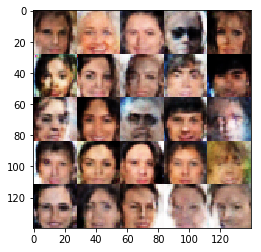

Epoch Number: 1/1, Discriminator Loss: 1.260624, Generator Loss: 1.020537
Epoch Number: 1/1, Discriminator Loss: 1.244751, Generator Loss: 0.721100
Epoch Number: 1/1, Discriminator Loss: 1.079527, Generator Loss: 1.309775
Epoch Number: 1/1, Discriminator Loss: 1.610179, Generator Loss: 0.394620


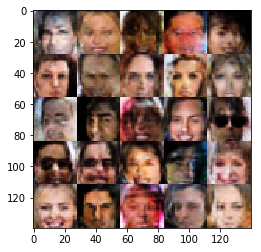

Epoch Number: 1/1, Discriminator Loss: 1.265783, Generator Loss: 0.623364
Epoch Number: 1/1, Discriminator Loss: 2.546191, Generator Loss: 0.130363
Epoch Number: 1/1, Discriminator Loss: 2.104921, Generator Loss: 0.208158
Epoch Number: 1/1, Discriminator Loss: 1.006256, Generator Loss: 1.603339


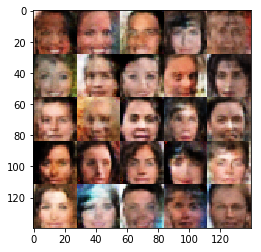

Epoch Number: 1/1, Discriminator Loss: 1.237927, Generator Loss: 0.630758
Epoch Number: 1/1, Discriminator Loss: 0.753644, Generator Loss: 1.466097
Epoch Number: 1/1, Discriminator Loss: 1.498854, Generator Loss: 0.451188
Epoch Number: 1/1, Discriminator Loss: 1.265945, Generator Loss: 0.601440


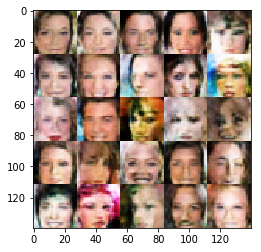

Epoch Number: 1/1, Discriminator Loss: 1.636157, Generator Loss: 0.407095
Epoch Number: 1/1, Discriminator Loss: 1.044121, Generator Loss: 0.956638
Epoch Number: 1/1, Discriminator Loss: 0.633700, Generator Loss: 1.483110
Epoch Number: 1/1, Discriminator Loss: 1.060456, Generator Loss: 0.839675


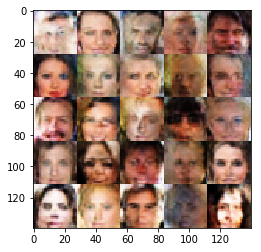

Epoch Number: 1/1, Discriminator Loss: 1.250954, Generator Loss: 0.772146
Epoch Number: 1/1, Discriminator Loss: 1.060778, Generator Loss: 0.764578
Epoch Number: 1/1, Discriminator Loss: 1.758214, Generator Loss: 0.334276
Epoch Number: 1/1, Discriminator Loss: 1.173912, Generator Loss: 0.671603


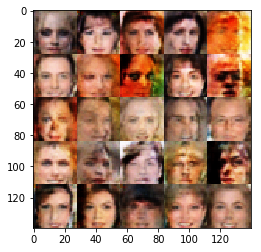

Epoch Number: 1/1, Discriminator Loss: 1.423869, Generator Loss: 1.856875
Epoch Number: 1/1, Discriminator Loss: 1.090626, Generator Loss: 0.731052
Epoch Number: 1/1, Discriminator Loss: 0.888595, Generator Loss: 1.018934
Epoch Number: 1/1, Discriminator Loss: 1.952627, Generator Loss: 0.277384


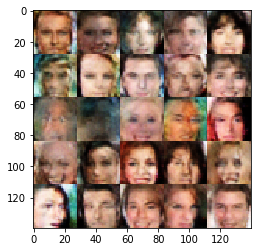

Epoch Number: 1/1, Discriminator Loss: 1.106066, Generator Loss: 0.947446
Epoch Number: 1/1, Discriminator Loss: 1.202062, Generator Loss: 0.673547
Epoch Number: 1/1, Discriminator Loss: 0.993924, Generator Loss: 0.911312
Epoch Number: 1/1, Discriminator Loss: 0.754969, Generator Loss: 1.354349


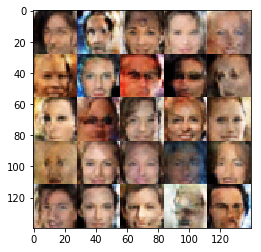

Epoch Number: 1/1, Discriminator Loss: 1.356501, Generator Loss: 0.578726


In [101]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.